## Изучение данных

In [1]:
#Импортируем все нужные библиотеки

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#Отключаем warnings

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('users_behavior.csv')

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В данном датасете в признаке `is_ultra` "0" обозначены пользователи тарифа **Смарт**, а "1" - пользователи тарифа **Ультра**. По условию данные были предобработаны.  
Выведем меры центральной тенденции по признакам

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Перед нами стоит задача **бинарной классификации** - необходимо предложить пользователям перейти с архивных тарифов на новые согласно их портрету

Оценим мультиколлинеарность признаков

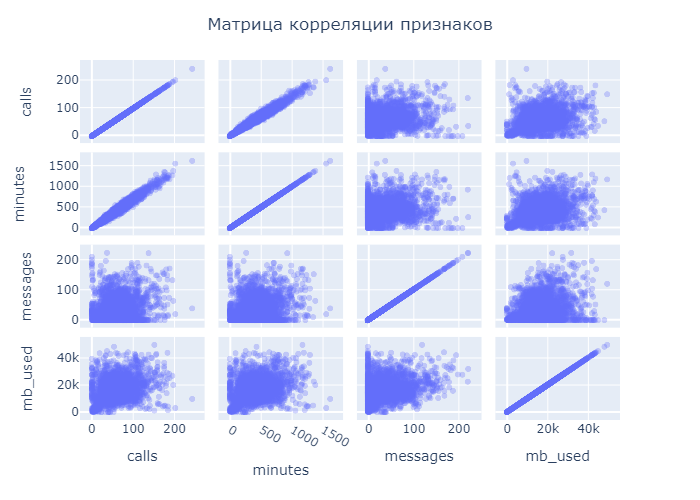

In [6]:
fig = px.scatter_matrix(df.drop('is_ultra', axis=1), opacity=0.3)
fig.update_layout(title_text='Матрица корреляции признаков', title_x=0.5)
fig.show('png')

In [7]:
df.drop('is_ultra', axis=1).corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


Признаки `calls` и `minutes` показывают высокие значения корреляции (сильная связь). Для обучения модели один из них (`calls`) можно не включать в выборки

## Создание выборок

Выделим из датасета признаки и целевой признак

In [8]:
features = df.drop(['is_ultra', 'calls'], axis=1)
target = df['is_ultra']

Разобьем датасет на обучающую, валидационную и тестовую выборки. Возьмем соотношение 60:20:20  - таким образом, валидационная и тестовые выборки будут составлять по 20% всего датасета.  
`train_test_split` умеет делить данные на две части. Применим её дважды - сначала получим обучающую выборку и промежуточную (60:40) и потом промежуточную разделим на валидационную и тестовую (50:50).

In [9]:
features_train, features_inter, target_train, target_inter = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=12345,
    stratify = target
)

In [10]:
#Проверяем размеры полученных датасетов, должны быть 60:40
len(features_train), len(features_inter) 

(1928, 1286)

In [11]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_inter, 
    target_inter, 
    test_size=0.5, 
    random_state=12345,
    stratify=target_inter
)

In [12]:
len(features_valid), len(features_test)

(643, 643)

## Исследование моделей

Создадим три модели:
1) Решающее дерево  
2) Случайный лес  
3) Логистическая регрессия  
   
Для каждой из них подберем лучшие гиперпараметры и сравним значение `accuracy`. Самая точная модель пройдет проверку на тестовой выборке

### Решающее дерево

In [13]:
#Создаем модель решающего дерева, проверяем значения параметра max_depth 
#В условие цикла вставим таймер из библиотеки tqdm
for depth in tqdm(range(1, 11)):  
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid) 
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 133.83it/s]

max_depth = 1 : 0.7402799377916018
max_depth = 2 : 0.7822706065318819
max_depth = 3 : 0.7900466562986003
max_depth = 4 : 0.7636080870917574
max_depth = 5 : 0.7791601866251944
max_depth = 6 : 0.7853810264385692
max_depth = 7 : 0.7900466562986003
max_depth = 8 : 0.7916018662519441
max_depth = 9 : 0.7916018662519441
max_depth = 10 : 0.7776049766718507


Максимальное значение `accuracy` было получено при значении глубины `max_depth = 8`. Сохраним модель в переменную

In [14]:
#Создаем модель, обучаем ее на выборке

model_1 = DecisionTreeClassifier(random_state=12345, max_depth=8)
model_1.fit(features_train, target_train)
prediction_1 = model_1.predict(features_valid)
accuracy_1 = accuracy_score(target_valid, prediction_1)

In [15]:
accuracy_1

0.7916018662519441

### Случайный лес

Как и в случае с решающим деревом, необходимо создать модель, подобрать гиперпараметры (в данном случае количество деревьев и глубину)

In [16]:
model_2 = None
accuracy_2 = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 101, 10)):
    for depth in range (1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > accuracy_2:
            model_2 = model
            accuracy_2 = accuracy
            best_est = est
            best_depth = depth

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


In [17]:
print("Accuracy лучшей модели на валидационной выборке:", accuracy_2, 
      "Количество деревьев:", best_est, 
      "Максимальная глубина:", best_depth
)

Accuracy лучшей модели на валидационной выборке: 0.8164852255054432 Количество деревьев: 50 Максимальная глубина: 12


Случайный лес показал лучшие результаты по метрике `accuracy`, нежели модель решающего дерева.

### Логистическая регрессия

In [18]:
model_3 = LogisticRegression(random_state=12345)
model_3.fit(features_train, target_train)
predictions_3 = model_3.predict(features_valid)
accuracy_3 = accuracy_score(target_valid, predictions_valid)

In [19]:
accuracy_3

0.8009331259720062

### Дообучение моделей

Мы подобрали гиперпараметры для каждой из трех моделей, теперь можно дообучить модели на train+valid выборке, чтобы не терять данные.  
Для этого сначала объеденим выборки с помощью `concat` и проверим правильность объединения по индексам

In [20]:
features_learn=pd.concat([features_train, features_valid])
features_learn

,minutes,messages,mb_used
2294,484.49,11.0,22454.35
1759,328.88,24.0,20511.93
529,705.05,18.0,22130.74
1599,135.52,48.0,13152.50
1868,159.55,0.0,14780.00
...,...,...,...
1554,618.35,56.0,19343.02
2018,468.96,10.0,28630.32
2981,317.27,27.0,13716.00
1391,202.92,25.0,12603.80


In [21]:
target_learn=pd.concat([target_train, target_valid])
target_learn

2294    0
1759    0
529     1
1599    0
1868    0
       ..
1554    0
2018    0
2981    0
1391    0
2434    0
Name: is_ultra, Length: 2571, dtype: int64

In [22]:
model_1.fit(features_learn, target_learn)
model_2.fit(features_learn, target_learn)
model_3.fit(features_learn, target_learn)

LogisticRegression(random_state=12345)

### Выводы

In [23]:
predictions_train_1 = model_1.predict(features_train)
predictions_train_2 = model_2.predict(features_train)
predictions_train_3 = model_3.predict(features_train)
accuracy_train_1 = accuracy_score(target_train, predictions_train_1)
accuracy_train_2 = accuracy_score(target_train, predictions_train_2)
accuracy_train_3 = accuracy_score(target_train, predictions_train_3)

In [24]:
best_accuracy = [accuracy_train_1, accuracy_train_2, accuracy_train_3]
best_model = ['решающее дерево', 'случайный лес', 'логистическая регрессия']
print(best_accuracy)
print(f'Самый высокий показатель accuracy равняется {max(best_accuracy):.2%}')
print(f'Cамая точная модель - {best_model[best_accuracy.index(max(best_accuracy))]}')

[0.8423236514522822, 0.8967842323651453, 0.7074688796680498]
Самый высокий показатель accuracy равняется 89.68%
Cамая точная модель - случайный лес


Все три модели смогли обучиться на обучающей выборке. Используя валидационную выборку мы подобрали наиболее подходящие гиперпараметры и доучили модели используя объединенную выборку train + valid.   
По метрике `accuracy` лидирует модель случайного леса, но при этом модель решающего дерева отстает от нее на ~5%, а модель логистической регрессии  - на ~19%. При этом модель логистической регрессии обучается в разы быстрее, что немаловажно, однако она явно underfitting.   
По результатам сравнения моделей, для проверки на тестовой выборке берем `model_2`.

## Проверка модели

Возьмем нашу модель случайного леса, предскажем значения целевого признака для тестовой выборки

In [25]:
test_prediction = model_2.predict(features_test)
accuracy_test = accuracy_score(target_test, test_prediction)

In [26]:
print(f'Accuracy модели случайного леса на тестовой выборке составила {accuracy_test:.2%}')

Accuracy модели случайного леса на тестовой выборке составила 84.14%


In [27]:
print(f'Разница между accuracy на обучающей и тестовой выборках составила {(accuracy_train_2 - accuracy_test):.2%}')

Разница между accuracy на обучающей и тестовой выборках составила 5.54%


Разница между точностью предсказаний на обучающей и тестовой выборках составила около 5.54%, значит, имеет место некий overfitting. Достигнута заданная в задании accuracy в 0.75.

Перед тем, как считать модель готовой, необходимо проверить ее на адекватность

## Проверка модели на адекватность

Используем DummyClassifier, чтобы проверить нашу модель на случайную подстановку значений

In [28]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(target_train)
score = dummy_clf.score(features_train, target_train)

In [29]:
print(f'Разница между accuracy моделей случайного леса и DummyClassifier составила {(accuracy_train_2 - score):.2%}')

Разница между accuracy моделей случайного леса и DummyClassifier составила 20.33%


Accuracy DummyClassifier меньше, нежели у нашей модели, причем значительно - целых 20%. Признаем модель адекватной (она смогла найти зависимости между признаками, а не проставила значения наобум)

## Общие выводы

Перед нами стояла задача бинарной классификации - по портретам клиентов построить рекомендательную модель тарифов ("Смарт" или "Ультра").   

На предоставленом датасете было обучено три модели - решающее дерево, случайный лес и логистическая регрессия. Результативность моделей оценивалась по величине метрики `accuracy`. Модель случайного леса показала самую высокую результативность на обучающей выборке. 

Далее перед нами стояла задача проверки `accuracy` модели на тестовой выборке и сравнить ее с проверкой на обучающей выборке. Модель успешно справилась с задачей, показав разницу в 8%. Финальная `accuracy` модели равняется 81.16%, что выше установленного в задании значения.  

Кроме того, была проведена проверка модели на адекватность, в ходе которого оценивалась способность модели находить взаимосвязи, а не предсказывать случайные значения, основываясь на частоте признака. Сравнение метрик нашей модели с `DummyClassifier` показало, что наша модель способна находить зависимости между признаками объектов.